<a href="https://colab.research.google.com/github/anshkaggarwal22/VirtualPowerPlantProject/blob/main/India_optimization_power_schedule_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing a power generation schedule


The electricity grid powers nearly every aspect of modern life — be it charging a phone, powering a factory, or mining Bitcoin.
Energy sector decision-makers must ensure a smooth and adequate power supply that caters to the growing power needs of modern life.
After all, with great power comes great responsibility.

Referenced Gurobi Optimization Jupyter Notebook


https://www.gurobi.com/jupyter_models/optimizing-a-power-generation-schedule/

In [ ]:
from google.colab import drive
WORK_DRIVE = '/content/drive'
drive.mount(WORK_DRIVE)

Mounted at /content/drive


In [ ]:
import os

WORK_AREA = WORK_DRIVE + '/MyDrive/Ansh Aggarwal/Models/Unit Commitment and Economic Dispatch'
#Change the working directory to the folder
os.chdir(WORK_AREA)
inputs_path = './inputs/'
outputs_path = './outputs/'
beopt_path = './BEopt/'

Managing the supply and demand of electricity can be a complex and challenging task. Assume that we know the set of all available power plants and the demand for power for each hour of a day. Can we create a schedule to decide how much power each plant should generate, and when to switch the plants "on" and "off"? How can we do so while minimizing the overall costs?

In this notebook, we model this decision-making problem using **mathematical optimization**. The first part of the notebook describes the datasets used. We use real data from the Northern India. The data includes historical demand for power as well as specific information about the power plants.

The second part of the notebook introduces the three components of a mathematical optimization model: the objective function to be optimized, the decision variables, and the constraints. In our power generation problem, the **objective** is to minimize the overall costs. The **decision variables** model the power generation schedule. The **constraints** capture basic requirements such as ensuring that the power supply meets the demand, as well as practical limitations such as the minimum and maximum production levels for each power plant. By finding the optimally cost-efficient schedule, this model helps power plant operators get the best output from their facilities while minimizing the overall costs.


Let's get started.

## The data

First, let us load the following packages needed to process and visualize the data.

In [ ]:
%pip install networkx seaborn
!pip install gurobipy

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import random
import numpy as np
import datetime
import gurobipy as gp
from gurobipy import GRB
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 23.7 MB/s eta 0:00:00


In [ ]:
# Gurobi WLS license file
# Your credentials are private and should not be shared or copied to public repositories.
# Visit https://license.gurobi.com/manager/doc/overview for more information.
WLSACCESSID='7c20083c-6e76-4bd3-a59f-e3295d0b2870'
WLSSECRET='79f2b807-3e71-469c-8540-0584e3829074'
LICENSEID=2396568

# Create an environment with your WLS license
params = {
"WLSACCESSID": WLSACCESSID,
"WLSSECRET": WLSSECRET,
"LICENSEID": LICENSEID,
}

### Historical power demand data

First, read the demand data.
The 'demand.csv' file contains the historical demand for power in Northern India from 2019.

This data is available for each hour of the year.

For the rest of this notebook, we mainly focus on two summer months (May, June) and two winter months (December, January).

Here, we will visualize a few data points for January 1st.

In [ ]:
df_hourly_demand = pd.read_csv(beopt_path + 'Normalize_BEopt_and_Demand.csv')

df_hourly_demand['Hourly_Demand_Date'] = pd.to_datetime(df_hourly_demand['Hourly_Demand_Date'], format='%m/%d/%Y %H:%M', errors = 'coerce')
hour_demand = df_hourly_demand.set_index(['Hourly_Demand_Date'])['Demand_76_F_MW'].to_dict()
Day = set(hour_demand.keys())

We can visualize the power usage in Georgia on July 1st, 2011.

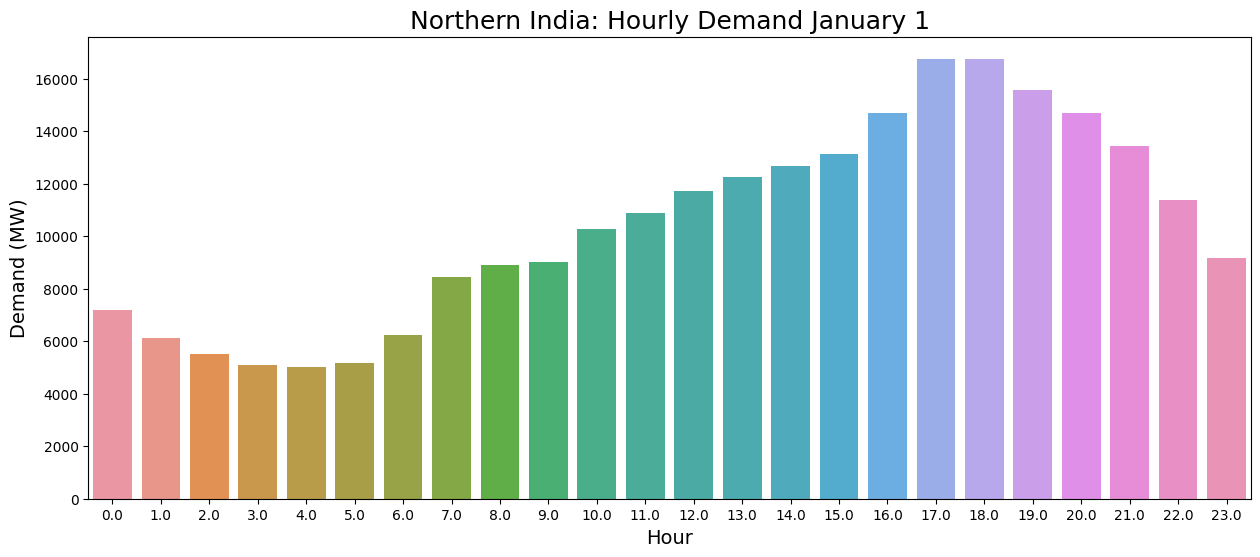

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(x=df_hourly_demand['Hourly_Demand_Date'].dt.hour, y=df_hourly_demand['Demand_76_F_MW'], ci=None)
plt.xlabel('Hour', size=14)
plt.ylabel('Demand (MW)', size=14)
plt.title("Northern India: Hourly Demand January 1", size=18)
plt.show()

The power utilization is higher in the evenings than in the mornings.

#All Dictionaries of Parameters

Additionally, we also have a limit on how much the power generation schedule can **ramp up** or **ramp down** the power generation between successive hours.
This limit ensures that the plants are not forced make drastic changes to their generation schedule.
_________________________
Finally, we load the cost data. There are three types of costs: fuel costs, start-up and shut-down costs.
We have historical yearly average data (for 2019) on these costs based on fuel type.

First is the **fuel costs**, which measure the cost of producing *one* MWh of power.
________________________
The second and third are the **startup** and **shutdown costs**, which penalize whenever a plant is started up and shut down. Incorporating these costs in the model ensures a stable power generation schedule.
___________________________
There are several other data points factored into our model such as minimum off time, minimum off time, source emissions, etc listed below in the series of dictionaries.

In [ ]:
df_hourly_demand = pd.read_csv(beopt_path + 'Normalize_BEopt_and_Demand.csv')
df_hourly_demand['Hourly_Demand_Date'] = pd.to_datetime(df_hourly_demand['Hourly_Demand_Date'], format='%m/%d/%Y %H:%M', errors = 'coerce')

df_power_plant_data = pd.read_csv(inputs_path + 'power_plant_data.csv')
df_power_plant_data['nameplate_capacity'] = df_power_plant_data['nameplate_cap (max_gen)_[MW]']

plant_fuel_source = df_power_plant_data.set_index('unit_name').typeof_fuel.to_dict() # plant type for each plant
perc_ramp_rate = df_power_plant_data.set_index('unit_name')['PERC_RAMP_RATE'].to_dict() # ramp rate for each plant
fuel_costs = df_power_plant_data.set_index('unit_name')['FUEL_COSTS'].to_dict() # fuel cost for each plant
startup_cost = df_power_plant_data.set_index('unit_name')['STARTUP_COST'].to_dict() # startup cost for each plant
shutdown_cost = df_power_plant_data.set_index('unit_name')['SHUTDN_COST'].to_dict() # shutdown cost for each plant
capacity = df_power_plant_data.set_index('unit_name').nameplate_capacity.to_dict() # capacity for each plant
heat_rate = df_power_plant_data.set_index('unit_name').HEAT_RATE.to_dict() # heat rate for each plant
min_on = df_power_plant_data.set_index('unit_name').MIN_ON_TIME.to_dict() # min off time for each plant
min_off = df_power_plant_data.set_index('unit_name').MIN_OFF_TIME.to_dict() # min on time for each plant
source_emiss = df_power_plant_data.set_index('unit_name').SOURC_EMISS_CARBN_FPRINT.to_dict() # source emissions for each plant

### Power plant data

Next, let us load information about the power plants.

The real dataset has 129 power plants. Solving the optimization problem using the large dataset requires a full Gurobi license.

Power plants come in different types based on the type of fuel they consume.
From our dataset, there are **five types** of power plants: coal, nuclear, gas hydro, and biomass.

The **fuel** used by each power plant is also loaded from the files. This information is necessary to determine some of the fuel-dependent costs.

We now load this data.

In [ ]:
Plants = set(df_power_plant_data['unit_name'].unique())                          # set of all power plants

P_H = set([i for i in Plants if plant_fuel_source[i]=='Hydro'])             # set of all hydro plants
P_C = set([i for i in Plants if plant_fuel_source[i]=='Coal'])             # set of all coal plants
P_N = set([i for i in Plants if plant_fuel_source[i]=='Nuclear'])             # set of all nuclear plants
P_G = set([i for i in Plants if plant_fuel_source[i]=='Gas'])             # set of all gas plants
P_B = set([i for i in Plants if plant_fuel_source[i]=='Biomass'])             # set of all biomass plants


### Plant capacities and limits

The overall goal is to determine the amount of power to generate from each plant. This amount must be within the plant's minimum and maximum production limits (in MWh). See below for a visualization of the maximum production limits for the ten plants.

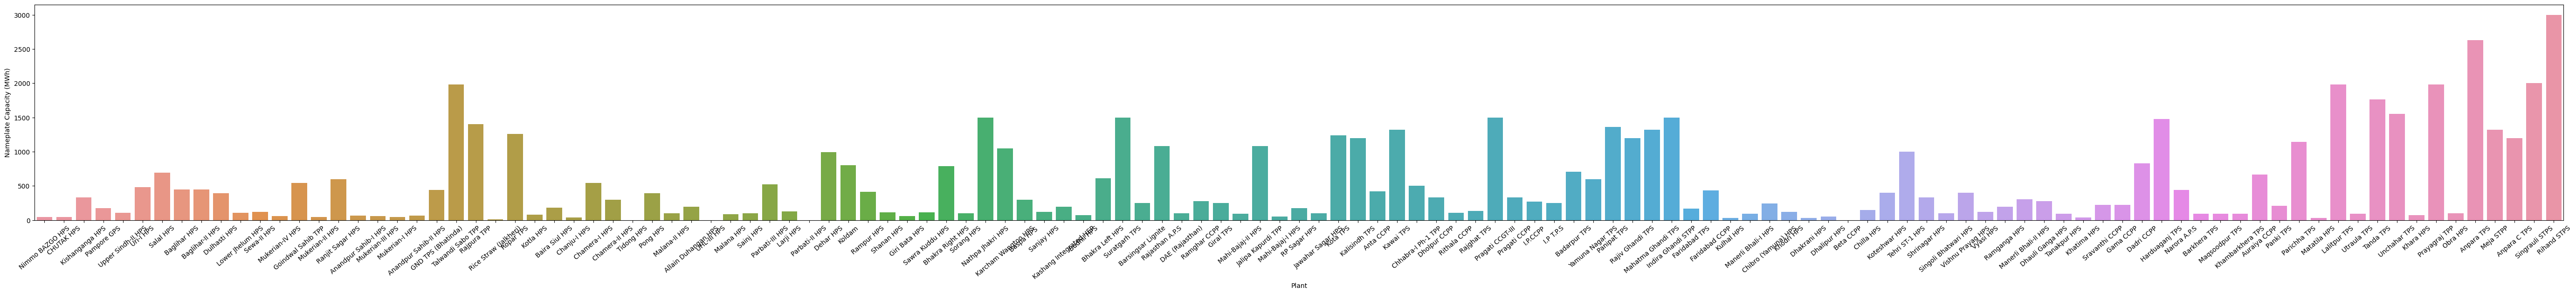

In [ ]:
plt.figure(figsize=(70, 6))
capacity_plot = sns.barplot(x=list(capacity.keys()), y=[capacity[k] for k in capacity])
capacity_plot.set_xticklabels(capacity_plot.get_xticklabels(), rotation=40);
capacity_plot.set(xlabel='Plant', ylabel='Nameplate Capacity (MWh)');
plt.show()

Clearly, coal plants are capable of the highest production capacities, followed by nuclear and hydro plants.

Moreover, different fuel source power plants, when turned "on," they have to generate at least x% of its maximum capacity.

In [ ]:
hy = {i: .6 for i in P_H} # min hydro % generation when on
c = {i: random.uniform(0.25,.4) for i in P_C} # min coal % generation when on
n = {i: .75 for i in P_N} # min nuclear % generation when on
g = {i: random.uniform(0.4,.5) for i in P_G} # min gas % generation when on
b = {i: 0.25 for i in P_B} # min biomass % generation when on

Fuel Cost Graph for Each Power Plant

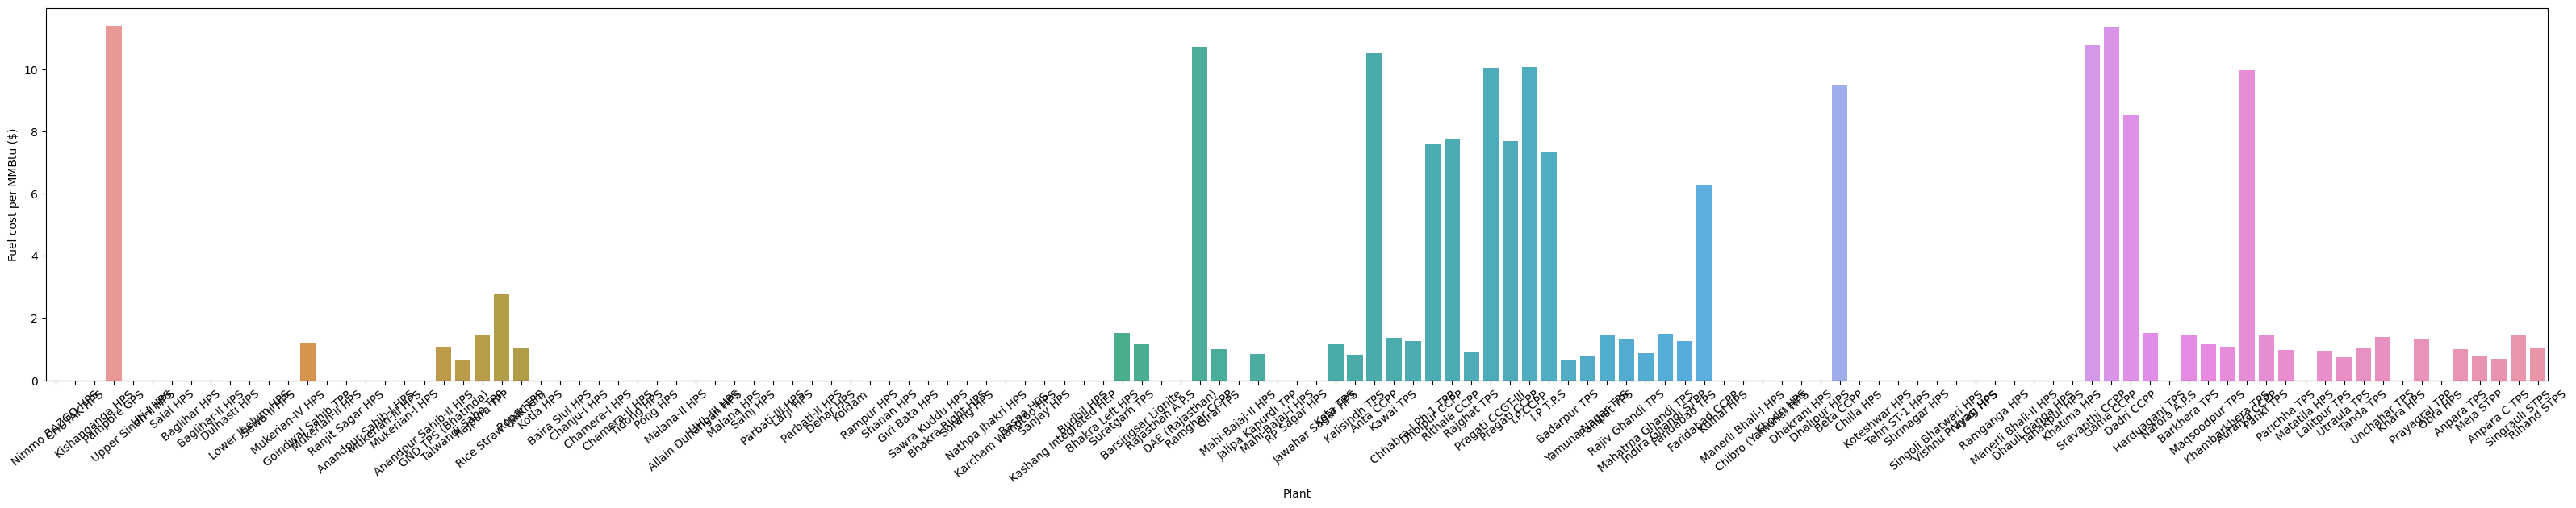

In [ ]:
# plot the fuel costs
plt.figure(figsize=(40,6))
fuelcost_plot = sns.barplot(x=list(fuel_costs.keys()), y=[fuel_costs[k] for k in fuel_costs])
fuelcost_plot.set_xticklabels(fuelcost_plot.get_xticklabels(), rotation=40);
fuelcost_plot.set(xlabel='Plant', ylabel='Fuel cost per MMBtu ($)');
plt.show()

# Optimization model

We will now address the decision-making problem.
Using the ten power plants, and knowing their capabilities and limitations, what is the most cost-effective way to generate power from them in order to completely satisfy the energy demand in Northern India?

We can capture these complex considerations in a mathematical optimization model.
An optimization model finds the **best solution** according to an **objective function** such that the solution satisfies a set of **constraints**.
Here, a solution is expressed as a vector of real values or integer values called **decision variables**.
Constraints are a set of equations or inequalities written as a function of the decision variables.

For our power generation problem, the objective is to minimize the overall costs.
The decision variables represent the power generation schedule for each power plant.
The limits and capacities of the power plants are captured using the constraints.

Let us now define the inputs to the model. The subscripts $i$ and $h$ will be used to denote each power plant and hour, respectively.

### Input Parameters
Sets:
- $P\ (P_H)$: set of (hydro) power plants,
- $P\ (P_C)$: set of (coal) power plants,
- $P\ (P_N)$: set of (nuclear) power plants,
- $P\ (P_G)$: set of (gas) power plants,
- $P\ (P_B)$: set of (biomass) power plants,
- $H$: set of hours.

Demand, capacity and speed limits:
- $d_h$: power demand for each hour $h$,
- $c_i$   : maximum power generation capacity for power plant $i$,
- $h_i, c_i$, $b_i$, $n_i$, $g_i$ : minimum % power that must be generated from each type of power plant $i$,
- $pr_i$: percent ramp up/ramp down speed for power plant $i$.

Costs:
- $f_i $: fuel costs for power plant $i$,
- $st_i, sd_i$: startup and shutdown costs for power plant $i$.

Emissions:
- $hr $: heat rate for power plant $i$,

Time:
- $min_n $: minimum on time for power plant $i$,
- $min_f $: minimum off time for power plant $i$,


## Objective: Minimize the total costs

Having defined the variables, we now tell the model what to optimize for.
We want to minimize the overall costs composed of five components - fuel, health, operating, startup and shutdown costs.
We can mathematically express the total cost using the decision variables as the following,

\begin{align*}
\sum_{\textrm{plant}\ i} \sum_{\textrm{hour}\ h} (f_i z_{i,h}hr_i + .035se_iz_{i,h} + s_i v_{i,h} + t_i w_{i,h})
\end{align*}

We now add this objective function to the model using the **setObjective** function.
The key input is the summation of all the terms.
Below is one way to add the five components one by one.

### Constraint: Meet demand

First, we want to make sure that the total power generated by all the power plants in each hour is equal to the power demand in that hour.
This requirement can be mathematically expressed as the following equality constriant for each hour $h$.

\begin{align*}
\sum_{\textrm{plant}\ i} z_{i,h} &= d_h
\end{align*}

We now add this constriant to our model using the **addConstrs** function.

### Constraint:  Maximum and minimum generation levels

We make sure that the power generated from each plant does not exceed the plant's maximum capacity (denoted by $c_i$). This constraint can be expressed by the inequality $z_{i,h} \leq c_i$ for each plant and hour.
We also want to make sure that when the plant is "off", i.e. when $u_{i,h}=0$, we do not generate any power, i.e. $z_{i,h}=0$.
We can capture this by the following inequality for each plant $i$ and hour $h$,

\begin{align*}
z_{i,h} \leq c_i u_{i,h}
\end{align*}

Furthermore, recall that each plant needs to generate a certain minimum % amount of power (denoted by $m_i$).
Nuclear power plants must produce at least 80% of their capacity and the rest of the plants must produce at least 1% of their capacity.
This can be expressed by the following inequality for each power plant $i$ and hour $h$,

\begin{align*}
z_{i,h}  \geq m_i c_i u_{i,h}
\end{align*}

Note that this constraint also ensures that when there is no power generated, i.e., $z_{i,h} = 0$, then the plant is said to be turned "off", i.e., $u_{i,h} =0$.

We now add these constraints to the model.

### Constraint:  Nuclear plants are always on

Unlike the other types of power plants, nuclear power plants cannot be easily shut down within a short period of time.
In our model, we add a constriant that ensures that the nuclear power plants are always "on".
This can be done either by setting the $u$ variable to be $1$, or the following for each nuclear plant $i$ and hour $h$:

\begin{align*}
 z_{i,h} \geq m_i c_i
\end{align*}

We now add these constraints to the model.

### Constraint:  Max rampdown, rampup


While operating the power plants, it is preferable not to cause drastic changes in power generation.
We can enforce a limit on the speed at which power generation is ramped up or ramped down.
For each plant $i$, the quantity $z_{i,h} - z_{i,h-1}$ gives the difference in power generated between hours $h-1$ and $h$.


We can define constraints that ensure that the magnitude of  quantity is no more than a certain percentage of the maximum capacity.
This percentage is given by the ramp up/ramp down speed denoted by $r_i$.
These constraints can be mathematically expressed as the following for each plant $i$ and hour $h>1$,

\begin{align*}
-r_i c_i   \leq z_{i,h} - z_{i,h-1} \leq r_i c_i
\end{align*}

We now add these constraints to the model.

### Constraint:  Link startup/shutdown variables to "on"/"off" variables

Finally, we link the startup/shutdown variables ($v$ and $w$) with the "on"/"off" variables ($u$).
Comparing two successive hours $h-1$ and $h$, the quantity $u_{i,h} - u_{i,h-1}$ can take one of three possible values: -1, 0, 1.
If it is -1, it means that the plant is "switched off" for hour $h$, forcing the variable $w_{i,h}$ to be $1$.
If it is 1, it means that the plant is "switched on" for hour $h$, forcing the variable $v_{i,h}$ to be $1$.
If it is 0, it means that the plant is neither "switched on" nor "switched off" for hour $h$; forcing the variables $w_{i,h}$ and $v_{i,h}$ to be $0$.

All of these possible combinations can be elegantly expressed using the following equality constraint for each plant $i$ and hour $h>1$,

\begin{align*}
v_{i,h} - w_{i,h} = u_{i,h} - u_{i,h-1}
\end{align*}

We now add these constraints to the model.


### Constraint:  Minimum Up and Down Time for each Power Plant

Minimum up time
\begin{align*}
\sum_{t=1}^{min \{T, T_i^U \}} u_{i}(t) - min \{T, T_i^U \} = 0 \quad & \quad \forall \quad i \in G_{thermal} \\
\sum_{t=u_{i,j}}^{t+T_i^U,t}{u_i(t)} \geq T_i^Uv_{i}(t), \quad T_i^U = min \{ T-t+1, V_i^U\} \quad & \quad \forall \quad t = min \{T, T_i^U \}+1,...,T \\
\end{align*}

Minimum down time
\begin{align*}
\sum_{t=1}^{\min \{ T,T_i^D \} } {u_{i}(t)=0} \quad & \quad \forall \quad i \in G_{thermal}, t \in T \\
u_{g}(t) + \sum_{j=max \{ 1, t-V_{i}^D \} }{w_{i}(j) \leq 1} \quad & \quad \forall \quad t = \min \{ T,T_g^D \} +1, ... , T\\
\end{align*}

# Full model

Below is the complete code to build and solve the optimization model.

### Formulation

In [ ]:
N_HOURS = 24

env = gp.Env(params=params)
model = gp.Model("powergeneration", env=env)

model.setParam('MIPGap', 0.05)
model.setParam('Timelimit', 300)

hour_demand = df_hourly_demand.set_index(['Hourly_Demand_Date'])['Demand_76_F_MW'].to_dict()

daily_results = []

for n_day in range(349,350):
  day = pd.Timestamp('2019-01-01 00:00:00') + datetime.timedelta(hours=N_HOURS*(n_day-1))
  date_list = [day + datetime.timedelta(hours=hour) for hour in range(N_HOURS)]
  hour_demand_sub = {k: hour_demand[k] for k in date_list}
  demand_other_sect = (sum(hour_demand_sub.values())/N_HOURS)*0.7
  hour_demand_mod = {k: hour_demand[k] + demand_other_sect for k in date_list}

  # Define the variables
  z = model.addVars(Plants, date_list, name="z", lb=0) # power generated in each plant for each hour
  u = model.addVars(Plants, date_list, name="u", vtype=GRB.BINARY) # is the plant on? for each plant and hour
  v = model.addVars(Plants, date_list, name="v", vtype=GRB.BINARY) # start up the plant? for each plant and hour
  w = model.addVars(Plants, date_list, name="w", vtype=GRB.BINARY) # shut down the plant? for each plant and hour

  # Set the objective function by adding all the costs
  objective = gp.quicksum(fuel_costs[i]*z[i,h]*heat_rate[i] for i in Plants for h in date_list) # fuel cost (FIX)
  objective += gp.quicksum(startup_cost[i]*z[i,h]*v[i,h] for i in Plants for h in date_list) # startup cost
  objective += gp.quicksum(shutdown_cost[i]*z[i,h]*w[i,h] for i in Plants for h in date_list) # shutdown cost
  objective += gp.quicksum(.035*source_emiss[i]*z[i,h] for i in Plants for h in date_list) #CO2 to relate emissions and costs, tri

  model.setObjective(objective, sense=GRB.MINIMIZE)

  # Set the constraint to meet the demand
  model.addConstrs((gp.quicksum(z[i,h] for i in Plants) == hour_demand_mod[h]) for h in date_list)

  # Set the constraint to set the minimum and maximum generation limits
  model.addConstrs(((z[i,h] <= capacity[i]*u[i,h]) for i in Plants for h in date_list), name='c_capac')

  model.addConstrs(((z[i,h] >= hy[i]*capacity[i]*u[i,h]) for i in P_H for h in date_list), name='c_capac_hy')
  model.addConstrs(((z[i,h] >= c[i]*capacity[i]*u[i,h]) for i in P_C for h in date_list), name='c_capac_coal')
  model.addConstrs(((z[i,h] >= g[i]*capacity[i]*u[i,h]) for i in P_G for h in date_list), name='c_capac_gas')
  model.addConstrs(((z[i,h] >= b[i]*capacity[i]*u[i,h]) for i in P_B for h in date_list), name='c_capac_biomass')

  # Set the constraint to always keep the nuclear power plants on
  model.addConstrs((z[i,h] >= n[i]*capacity[i]) for i in P_N for h in date_list)

  # Set the constraint to ensure that the ramp-up and ramp-down speeds are within limits
  model.addConstrs((z[i,date_list[h]]-z[i,date_list[h-1]] >= -perc_ramp_rate[i]*capacity[i]) for i in Plants for h in range(1,len(date_list)))
  model.addConstrs((z[i,date_list[h]]-z[i,date_list[h-1]] <= perc_ramp_rate[i]*capacity[i]) for i in Plants for h in range(1,len(date_list)))

  # Set the constraint to ensure that if the plant is turned on, the plant should be on
  model.addConstrs((v[i,h] <= u[i,h]) for i in Plants for h in date_list)

  # Set the constraint to ensure that if the plant is turned off, the plant should be off
  model.addConstrs((w[i,h] <= 1-u[i,h]) for i in Plants for h in date_list)

  # Set the constraint to link the startup/shutdown variables (v,w) to the on/off variables (u)
  model.addConstrs((v[i,date_list[h]] - w[i,date_list[h]] == u[i,date_list[h]] - u[i,date_list[h-1]]) for i in Plants for h in range(1,len(date_list)))

  # Minimum Uptime Constraint
  for i in list(Plants):
    for t_i in range(1, N_HOURS):
      k_i = max(t_i- min_on[i]+1,1)
      date_list_sub = [day + datetime.timedelta(hours=hour) for hour in range(k_i,t_i+1)]
      #print("value: ", k_i, "min_uptime: ",min_on[i])
      model.addConstr(gp.quicksum(v[i,h] for h in date_list_sub) <= u[i,date_list[t_i]])

  # Minimum Offtime Constraint
  for i in list(Plants):
    for t_i in range(1, N_HOURS):
        k_i = max(t_i - min_off[i] + 1, 1)
        date_list_sub = [day + datetime.timedelta(hours=hour) for hour in range(k_i, t_i + 1)]
        # print("value: ", k_i, "min_downtime: ", min_off[i])
        model.addConstr(u[i,date_list[t_i]] + gp.quicksum(w[i, h] for h in date_list_sub) <= 1)

  print("------------------------------------------------")
  print("------------------------------------------------")
  print("Solve model for period: {} to {}".format(date_list[0], date_list[-1]))
  # Solve the model
  model.optimize()

  system_cost_total = model.objVal # Total cost of everything

  co2_costs_total = sum(source_emiss[i] * z[i, h].X * 0.035 for i in Plants for h in date_list)
  startup_costs_total = sum(startup_cost[i] * v[i, h].X for i in Plants for h in date_list)
  shutdown_costs_total = sum(shutdown_cost[i] * w[i, h].X for i in Plants for h in date_list)
  coal_generation_total = sum(z[i, h].X for i in P_C for h in date_list)
  ng_generation_total = sum(z[i, h].X for i in P_G for h in date_list)
  nuclear_generation_total = sum(z[i, h].X for i in P_N for h in date_list)
  hydro_generation_total = sum(z[i, h].X for i in P_H for h in date_list)
  biomass_generation_total = sum(z[i, h].X for i in P_B for h in date_list)

  daily_results.append({
        'Date': day.strftime('%m/%d/%Y'),
        'system cost': system_cost_total,
        'CO2 costs': co2_costs_total,
        'startup cost': startup_costs_total,
        'shutdown cost': shutdown_costs_total,
        'Coal generation': coal_generation_total,
        'NG generation': ng_generation_total,
        'Nuclear generation': nuclear_generation_total,
        'Biomass Generation': biomass_generation_total,
        'Hydro Generation': hydro_generation_total,
    })
results_df = pd.DataFrame(daily_results)

#results_df.to_csv(outputs_path + '/UC Daily/' + '/70F/' 'Jun_unit_commitment_results_70_F.csv', index=False)

### Costs

In [ ]:
print("System cost: $",round(model.ObjVal,2)) # These are the fuel costs also
print("Operating costs: $",round(sum(fuel_costs[i]*z[i,h].X for i in Plants for h in date_list),2)) # These are the fuel costs also
print("Start-up costs: $",round(sum(startup_cost[i]*z[i,h].X*v[i,h].X for i in Plants for h in date_list),2))
print("Shut-down costs: $",round(sum(shutdown_cost[i]*z[i,h].X*w[i,h].X for i in Plants for h in date_list),2))
print("CO2 costs: $",round(.035*sum(source_emiss[i]*z[i,h].X for i in Plants for h in date_list),2))

System cost: $ 3323426.64
Operating costs: $ 51066.24
Start-up costs: $ 534496.89
Shut-down costs: $ 0.0
CO2 costs: $ 2133601.46


### Optimal power schedule / Power Demand

We now visualize the power generation schedule. The following code retrieves the optimal values for the decision variables by simply adding .X to each variable. We then visualize the amount of power generated by each plant for 24 hours and compare it to the power demand curve.

Power supply:


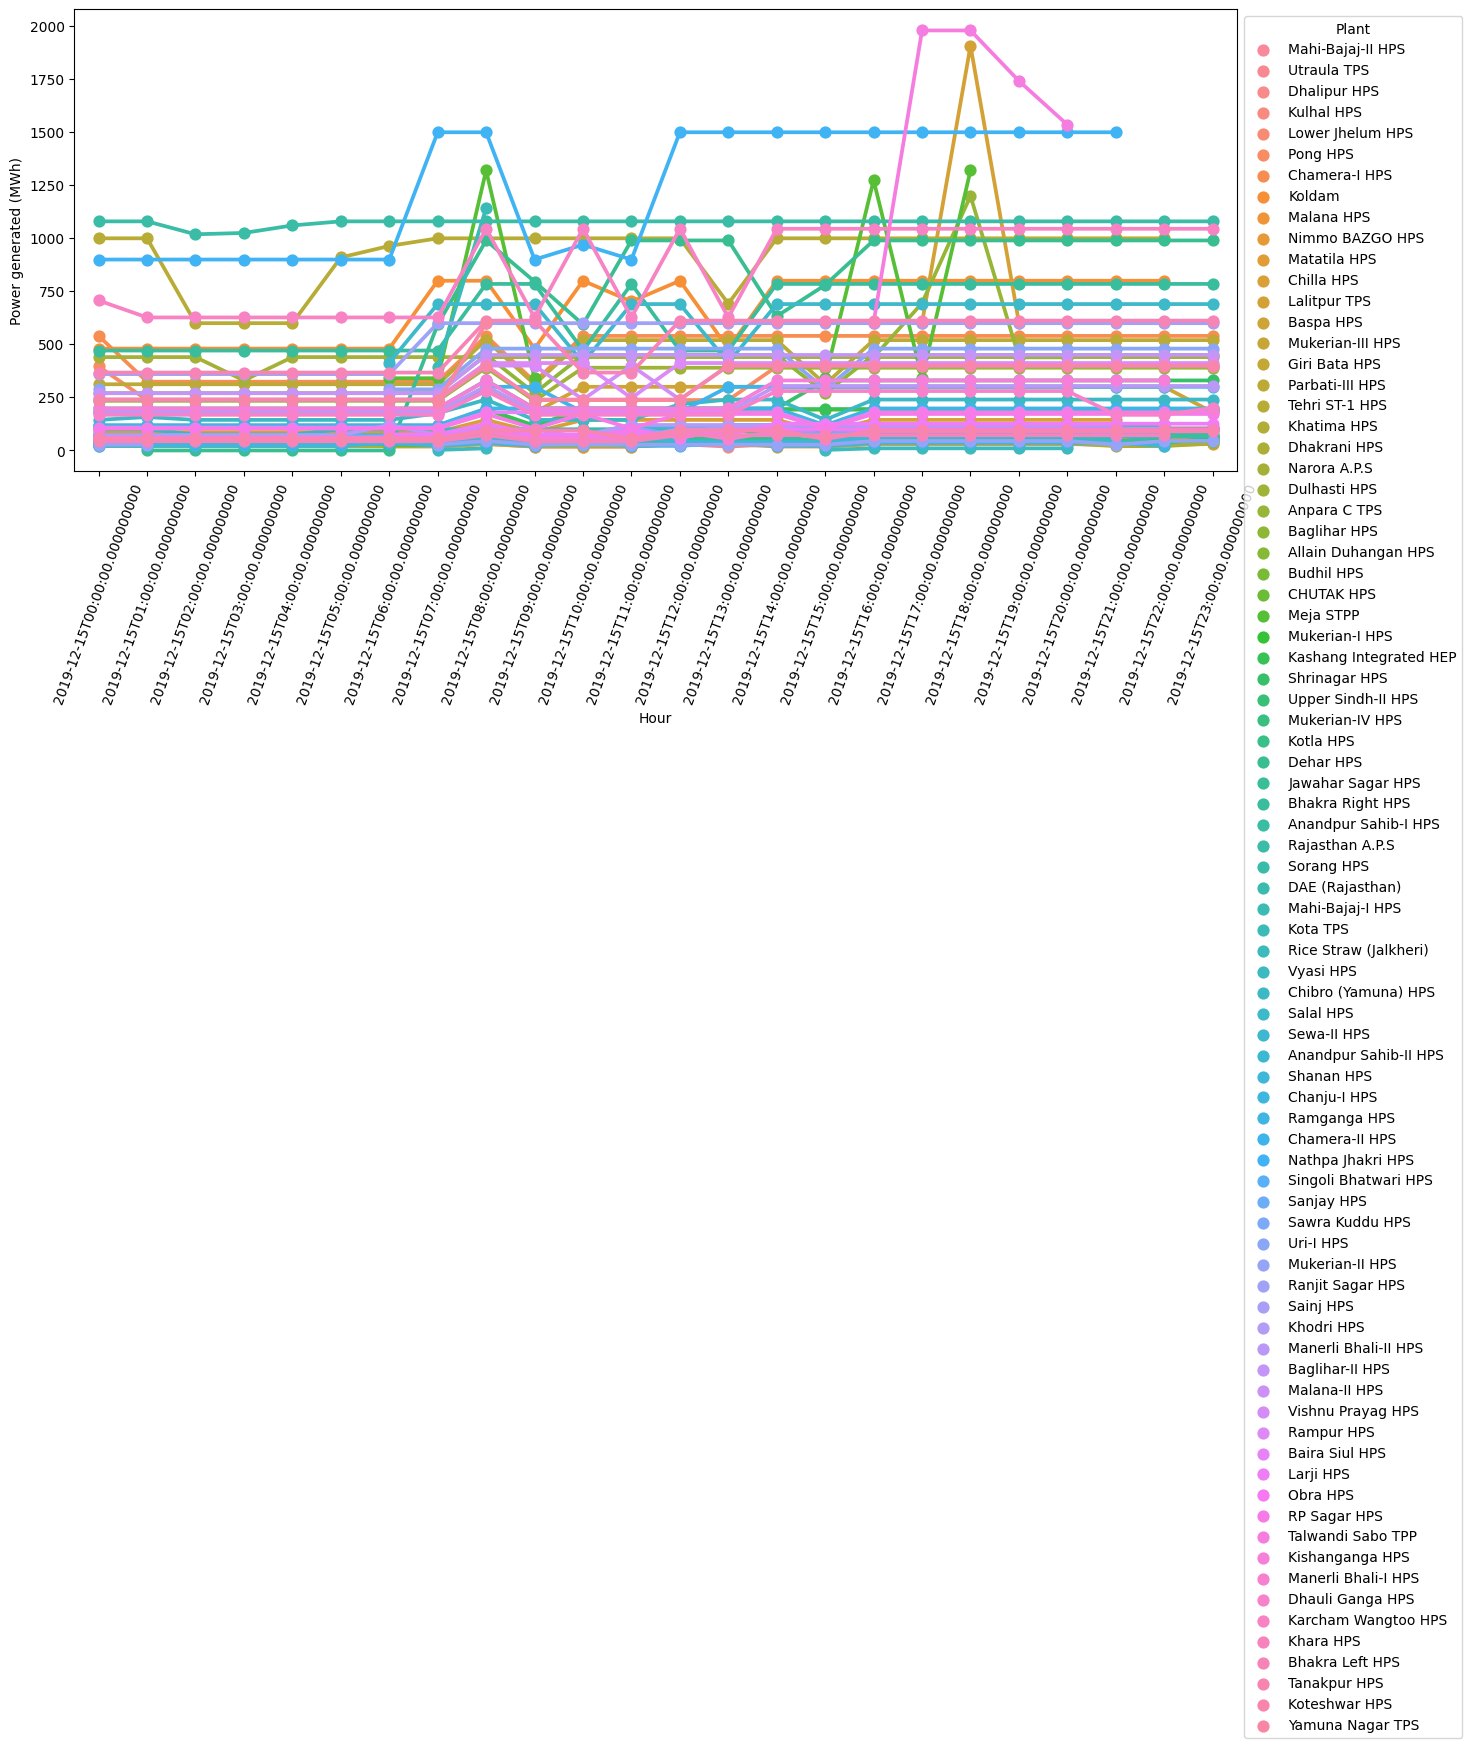

Power demand:


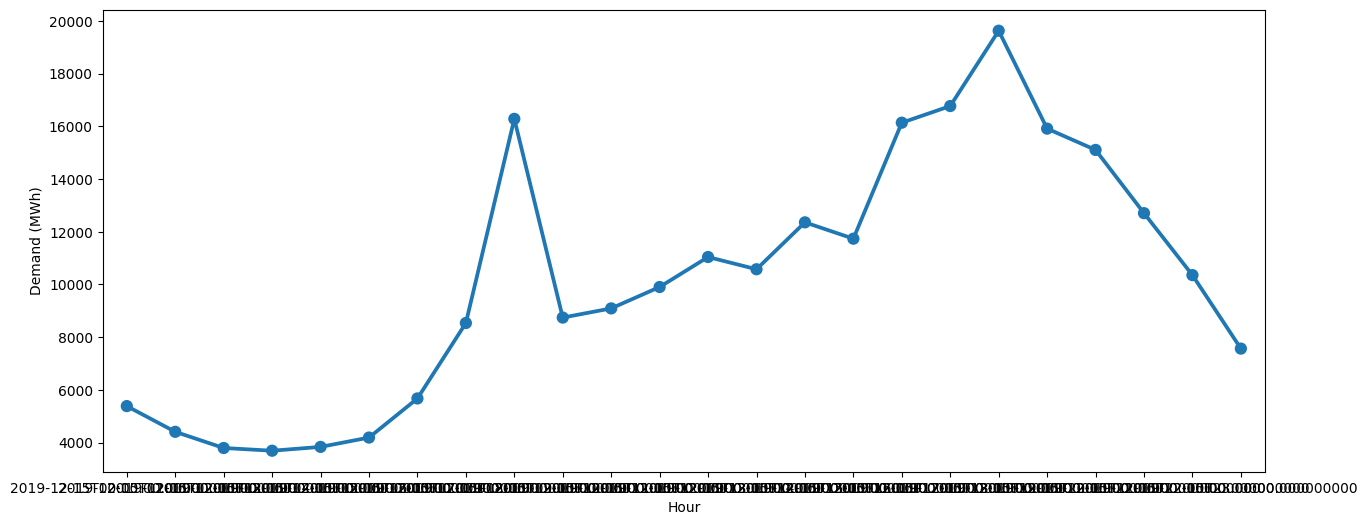

In [ ]:
solution = pd.DataFrame()
solution = pd.DataFrame(columns=['Hour', 'Power (MWh)', 'Plant'])
plant_hour_pairs = [(h,i) for i in Plants for h in date_list  if z[i,h].X > 0]

solution['Hour'] = [pair[0] for pair in plant_hour_pairs]
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]
solution['Power generated (MWh)'] = [z[pair[1],pair[0]].X for pair in plant_hour_pairs]

print("Power supply:")
fig, ax = plt.subplots(figsize=(15,6))
sns.pointplot(data=solution,x='Hour', y='Power generated (MWh)', hue='Plant')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=70)

plt.savefig(outputs_path + "/UC Daily/" + 'Dec_15_power_schedule_graph_base_case.png')
plt.show()

print("Power demand:")
fig, ax = plt.subplots(figsize=(15,6))
demand = pd.DataFrame(columns=['Hour', 'Demand (MWh)'])
demand['Hour'] = list(date_list)
demand['Demand (MWh)'] = [hour_demand[h] for h in date_list]
sns.pointplot(data=demand,x='Hour', y='Demand (MWh)')
plt.show()

###  Visualize the binary variables

We notice that the 'Other Coal' plant was switched "off" at one point and restarted at a later time. We can visualize how the switch "on" and "off" binary variables capture this scenario.

In [ ]:
sol = pd.DataFrame()
plant = 'Allain Duhangan HPS'
sol['hour'] = [h for h in date_list]
sol['v[i,h]'] = [v[plant,h].X for h in date_list]
sol['w[i,h]'] = [w[plant,h].X for h in date_list]
sol['u[i,h]'] = [u[plant,h].X for h in date_list]
sol['z[i,h]'] = [z[plant,h].X for h in date_list]
print(sol)